In [1]:
import numpy as np
from matplotlib import pyplot as plt, colors
import polars as pl

import pickle

In [2]:
import on_network_simulation as ons
import examine_transfers_for_sizes as esz
import do_simulation_on_network as dosim

In [3]:
reload(ons)

<module 'on_network_simulation' from '/home/davidwu/REPOS/echidna_network/on_network_simulation.py'>

In [4]:
szs = esz.quick_read("./concordant_networks/size_14.csv")

prob_final = dosim.load_prob_final_file("./probability_of_final_stay_by_shuffled_campus.csv")

In [5]:
G = dosim.load_temporal_graph("./concordant_networks/temponet_14_365.lgl")

In [6]:
snapshots = ons.load_snapshots("./conc_tempo_14_detailed/")

In [7]:
params = (0.4, 1./28)

In [114]:
tsim = ons.TemporalNetworkSimulation(szs, G, prob_final, params, track_movers=True)

In [9]:
tidx = 0

In [10]:
ssim = ons.SnapshotNoveauSimulation(szs, snapshots, prob_final, params)

/home/davidwu/REPOS/echidna_network/on_network_simulation.py:379: RuntimeWarning: invalid value encountered in divide
  Dp = D / Sig
/home/davidwu/REPOS/echidna_network/on_network_simulation.py:380: RuntimeWarning: invalid value encountered in divide
  Up = U / Sig


In [11]:
XNEXT = tsim.DIMENSIONS['NLOC']

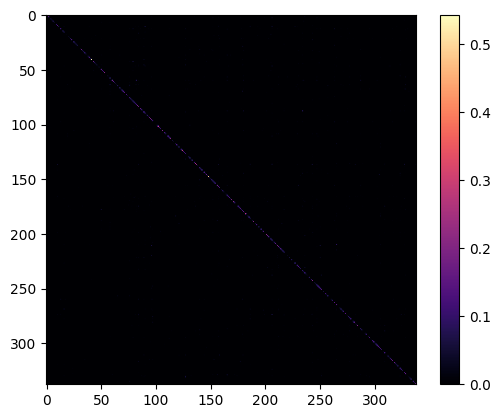

In [43]:
plt.imshow(tsim.PP[:XNEXT,XNEXT:].todense().reshape((338, -1, 338)).sum(axis=1), cmap='magma')
plt.colorbar()

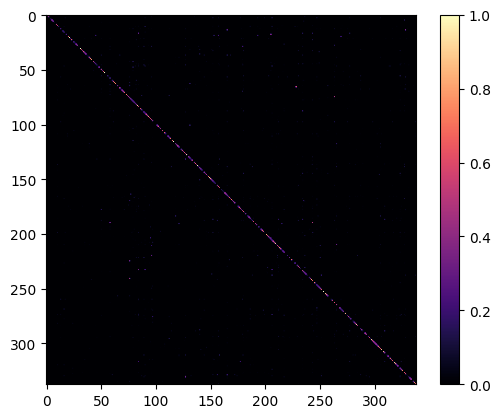

In [23]:
plt.imshow(ssim.transition_matrices['out'][0][:,XNEXT:], cmap='magma')
plt.colorbar()

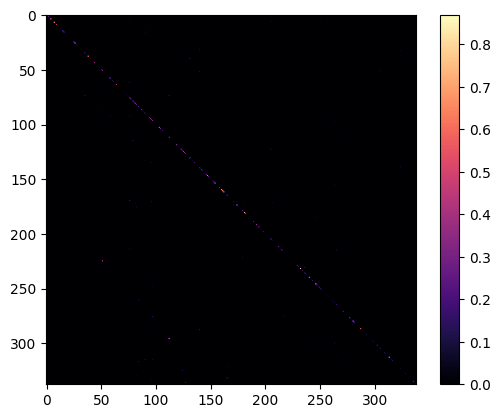

In [24]:
plt.imshow(ssim.transition_matrices['out'][0][:,:XNEXT], cmap='magma')
plt.colorbar()

In [46]:
V0 = G.vs.select(time_eq=0)

In [72]:
V00 = V0[0]
print(V00)

temporal_df = pl.from_records([
    {
    'loc': edge.target_vertex['loc'],
    'time': edge.target_vertex['time'],
    'weight': edge['weight']
    }

    for edge in V00.out_edges()
])

temporal_df = temporal_df.filter(pl.col('time') > 0).group_by('loc').agg(pl.col('weight').sum().alias('temporal_weight')).sort('loc')

igraph.Vertex(<igraph.Graph object at 0x7f8a4c873c40>, 27455, {'name': '(3805,0)', 'loc': 3805, 'time': 0})


In [77]:
snap_df = pl.from_records([{
    'loc': edge['target'],
    'weight': edge['departures'],
    }
    for edge in snapshots[0].vs.select(name_eq=V00['loc'])[0].out_edges()
])

snap_df = snap_df.with_columns(pl.col('loc').cast(pl.Int64)).select('loc', pl.col('weight').alias('snapshot_weight')).sort('loc')

In [79]:
edge_df = temporal_df.join(snap_df, on='loc')
edge_df.filter(pl.col('temporal_weight').ne(pl.col('snapshot_weight')))

loc,temporal_weight,snapshot_weight
i64,f64,f64


In [82]:
np.allclose(tsim.N.flatten(), ssim.hospital_sizes)

True

In [83]:
tsim.PP[:XNEXT, XNEXT:]

<338x87542 sparse array of type '<class 'numpy.float64'>'
	with 9230 stored elements in Compressed Sparse Row format>

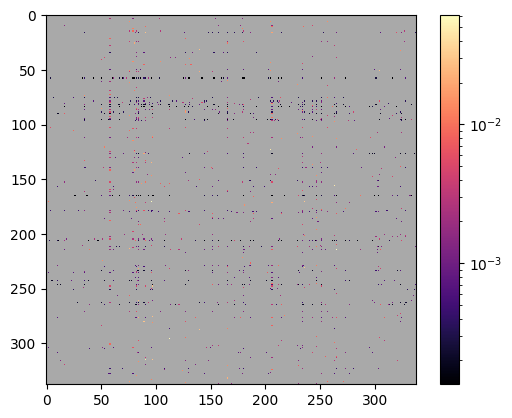

In [95]:
# plt.figure(figsize=(10,10))
plt.imshow(tsim.PP[:XNEXT, :XNEXT].todense(), cmap='magma', norm=colors.LogNorm(), interpolation='nearest')
plt.gca().set_facecolor('darkgrey')
plt.colorbar()

In [94]:
tsim.PP[:XNEXT, XNEXT:].todense().reshape((338, 338, -1), order='F').sum(axis=-1)

array([[0.07142857, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.1       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.18571429, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.15178571, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.07142857,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.16883117]])

In [101]:
ssim.transition_matrices['out'][0][:,XNEXT:]

array([[0.41666667, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.875     , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.54166667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.4047619 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.83333333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.65408805]])

In [107]:
ssim.leave_rate[0][0]

array([0.2155484])

In [110]:
tsim.removal_rate[:,0][0]

0.04411983164149542

In [105]:
ssim.transition_matrices['out'][0][:,:XNEXT]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.29166667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.33333333, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04402516]])

In [104]:
ssim.raw_transition_matrices['out'][0]

array([[0.07142857, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.1       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.18571429, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.15178571, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.07142857,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.16883117]])

In [115]:
tsim.seed(3, 5)

In [116]:
tsim.simulate(600)

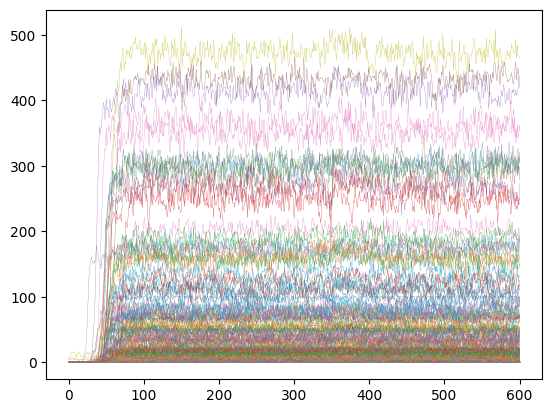

In [120]:
plt.plot(tsim.ts, tsim.history.T, lw=0.2);

/tmp/ipykernel_15538/3845351634.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tsim.ts[:-1], np.hstack(tsim.mover_out).T / tsim.history.T[1:,:], lw=0.2);
/tmp/ipykernel_15538/3845351634.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(tsim.ts[:-1], np.hstack(tsim.mover_out).T / tsim.history.T[1:,:], lw=0.2);


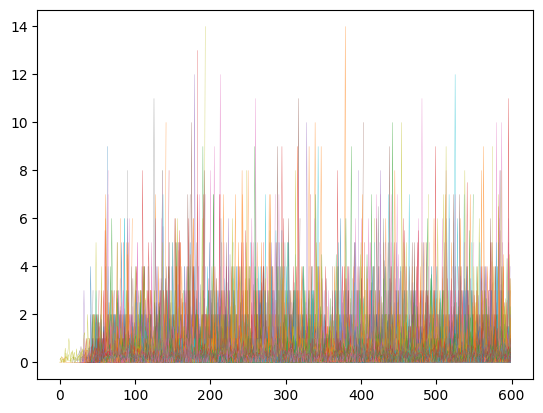

In [126]:
plt.plot(tsim.ts[:-1], np.hstack(tsim.mover_out).T / tsim.history.T[1:,:], lw=0.2);

In [140]:
for idx in range(50):
    tsim_i =  ons.TemporalNetworkSimulation(szs, G, prob_final, params, track_movers=True)
    tsim_i.seed(3, 5)
    tsim_i.simulate(365*3)
    with open(f"observation_tsims/simulation_result_{idx}.pkl", 'wb') as fp:
        pickle.dump(
            {'params': params, 
             'ts': tsim_i.ts,
             'history': tsim_i.history, 
             'mover_out': tsim_i.mover_out, 
             'mover_in': tsim_i.mover_in,
             'seed': (3, 5),
            }, fp)
    print(f"sim {idx} done")

sim 0 done
sim 1 done
sim 2 done
sim 3 done
Early termination: self.ts[-1] = 10.0
sim 4 done
sim 5 done
sim 6 done
sim 7 done
sim 8 done
Early termination: self.ts[-1] = 189.0
sim 9 done
sim 10 done
sim 11 done
sim 12 done
sim 13 done
sim 14 done
sim 15 done
sim 16 done
sim 17 done
sim 18 done
sim 19 done
sim 20 done
sim 21 done
sim 22 done
Early termination: self.ts[-1] = 35.0
sim 23 done
sim 24 done
sim 25 done
Early termination: self.ts[-1] = 25.0
sim 26 done
Early termination: self.ts[-1] = 35.0
sim 27 done
sim 28 done
sim 29 done
sim 30 done
sim 31 done
sim 32 done
sim 33 done
sim 34 done
sim 35 done
sim 36 done
sim 37 done
Early termination: self.ts[-1] = 42.0
sim 38 done
sim 39 done
sim 40 done
sim 41 done
Early termination: self.ts[-1] = 52.0
sim 42 done
sim 43 done
sim 44 done
sim 45 done
sim 46 done
sim 47 done
sim 48 done
sim 49 done


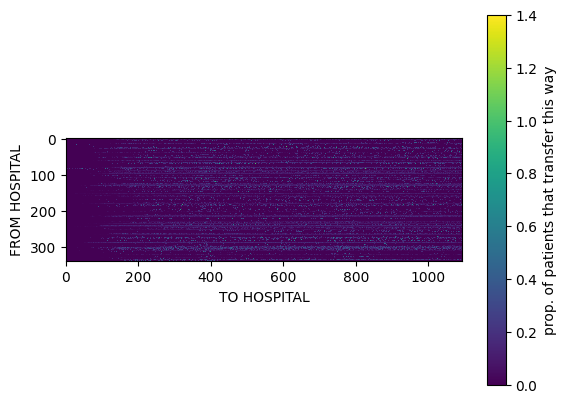

In [187]:
plt.imshow(np.hstack(tsim_i.mover_out) / tsim_i.N.reshape((-1, 1)), interpolation='nearest')
plt.xlabel('TO HOSPITAL')
plt.ylabel('FROM HOSPITAL')
plt.colorbar(label='prop. of patients that transfer this way')

In [147]:
np.where((np.hstack(tsim_i.mover_out) / tsim_i.N.reshape((-1, 1))) > 1.0)

(array([  1,   2,  32,  33,  70,  70, 102, 102, 113, 145, 268, 301]),
 array([ 995,  910, 1060,  983,  923, 1059,  178,  291,  327,  589,  511,
         648]))

In [149]:
tsim_i.PP.shape

(87880, 87880)

Text(0.5, 0, 'Proportion of patients that leave each day')

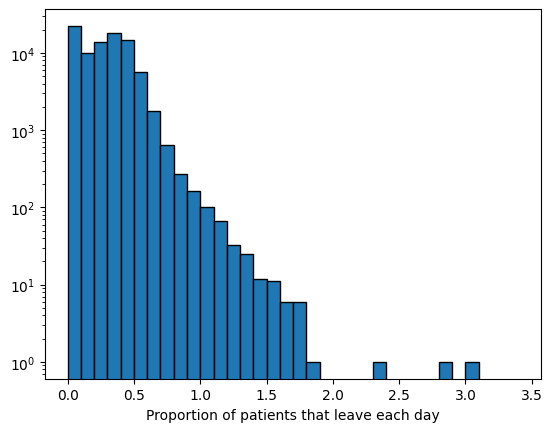

In [185]:
plt.hist(tsim_i.PP.sum(axis=1), bins=np.arange(0, 3.5, 0.1), ec='k')
plt.yscale('log')
plt.xlabel('Proportion of patients that leave each day')

Text(0, 0.5, 'proportion of patients that leave each day')

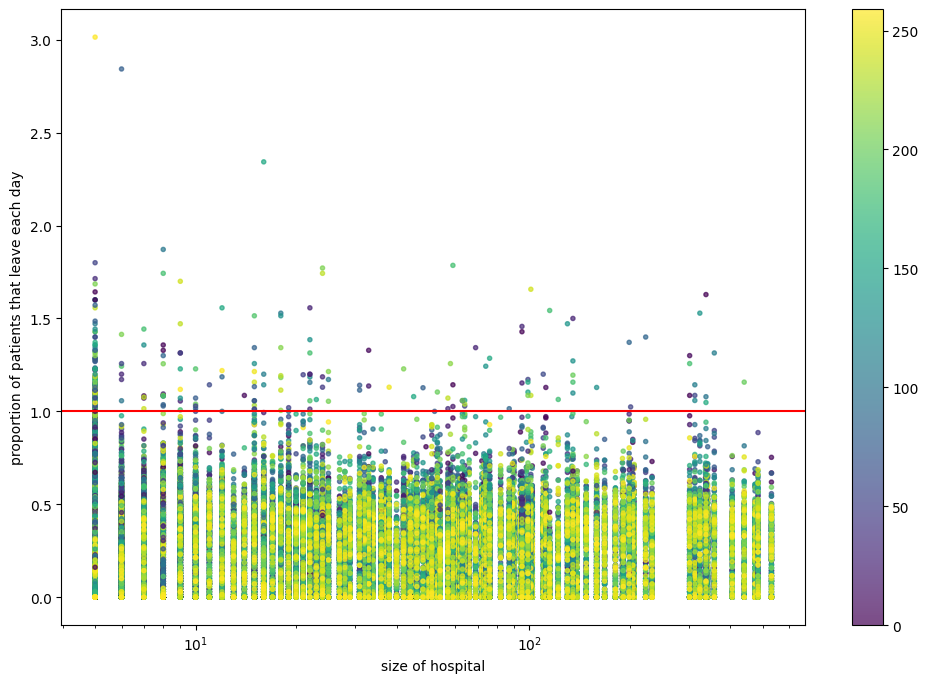

In [188]:
plt.figure(figsize=(12, 8))
plt.scatter(np.repeat(tsim_i.N, tsim_i.DIMENSIONS['NT']), tsim_i.PP.sum(axis=1), 
            c=np.repeat(np.arange(0, tsim_i.DIMENSIONS['NT']).reshape((-1, 1)), tsim_i.DIMENSIONS['NLOC'], axis=1).T.flatten(),
            alpha=0.7, marker='.')
plt.axhline(1.0, color='r')
plt.colorbar()
plt.xscale('log')
plt.xlabel('size of hospital')
plt.ylabel('proportion of patients that leave each day')

In [180]:
np.repeat(np.arange(0, tsim_i.DIMENSIONS['NT']).reshape((-1, 1)), tsim_i.DIMENSIONS['NLOC'], axis=1).T.flatten()

array([  0,   1,   2, ..., 257, 258, 259])

In [210]:
tminisim = ons.TemporalNetworkSimulation(szs, G, prob_final, (0.35, 1/28), track_movers=True, dt=0.1)

In [211]:
tminisim.reset()

In [212]:
tminisim.seed(3, 5)

In [213]:
tminisim.simulate(3*365)

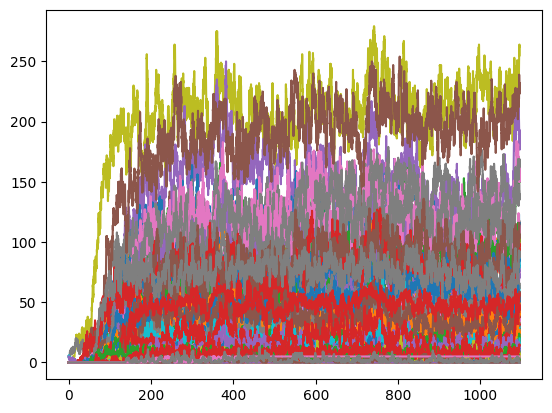

In [214]:
plt.plot(tminisim.ts, tminisim.history.T);

In [8]:
with open("./observation_tsims/simulation_result_mini_01.pkl", 'rb') as fp:
    tminisim_dict = pickle.load(fp)

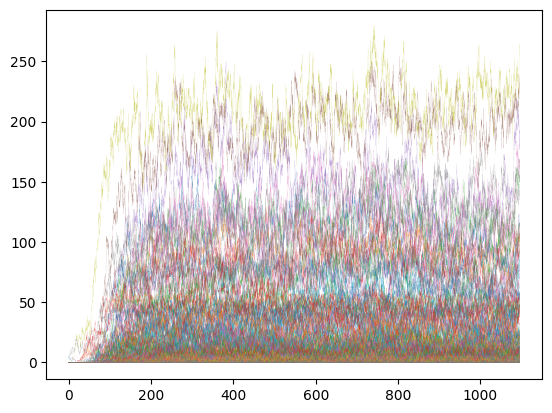

In [16]:
plt.plot(tminisim_dict['ts'], tminisim_dict['history'].T, lw=0.1, alpha=0.6);

In [18]:
from scipy import signal

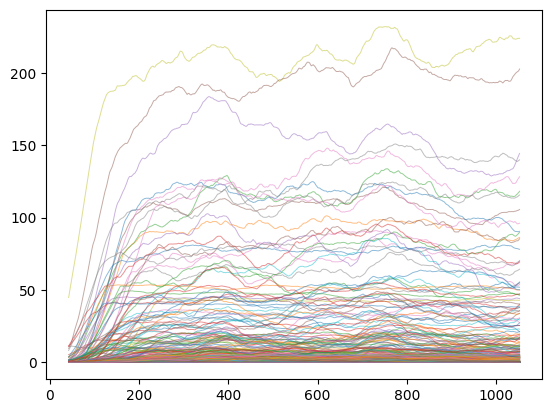

In [72]:
conv_n = 10*28*3

conv_ts = signal.convolve(tminisim_dict['ts'], np.ones(conv_n, dtype='float') / conv_n, mode='valid')

conv_xs = signal.convolve2d(tminisim_dict['history'], (np.ones(conv_n, dtype='float')/conv_n).reshape((1, -1)), mode='valid')

plt.plot(conv_ts, conv_xs.T, lw=0.7, alpha=0.5);

In [96]:
def moving_average(series, window_size):
    return signal.convolve(series, np.ones(window_size, dtype='float') / window_size, mode='valid')

def moving_average_2d_hrz(series, window_size):
    return signal.convolve2d(series, (np.ones(window_size, dtype='float')/window_size).reshape((1, -1)), mode='valid')

In [74]:
sarr = np.array([v for k,v in sorted(szs.items())])

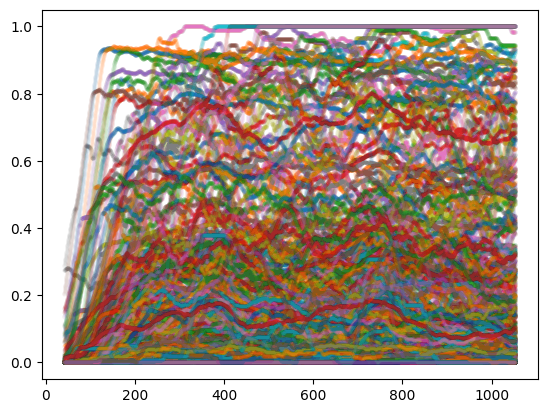

In [85]:
plt.scatter(conv_ts, conv_xs.T / sarr.reshape((1, -1)), c=);

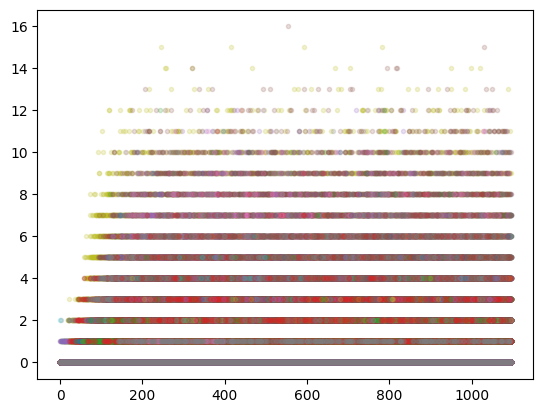

In [92]:
plt.plot(tminisim_dict['ts'][:-1], np.hstack(tminisim_dict['mover_out']).T, '.', alpha=0.2);

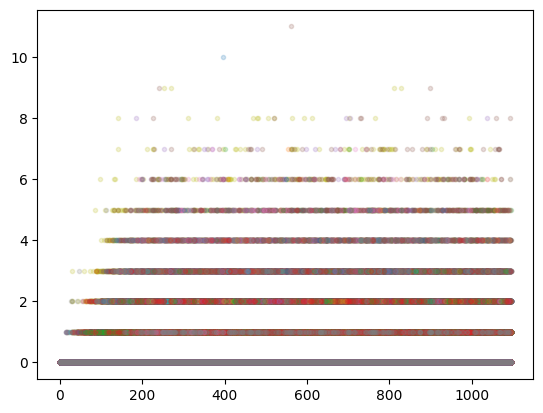

In [93]:
plt.plot(tminisim_dict['ts'][:-1], np.hstack(tminisim_dict['mover_in']).T, '.', alpha=0.2);

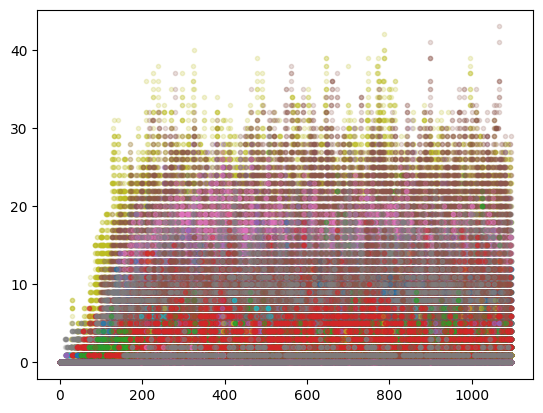

In [99]:
plt.plot(moving_average(tminisim_dict['ts'][:-1], 10), 10*moving_average_2d_hrz(np.hstack(tminisim_dict['mover_in']), 10).T , '.', alpha=0.2);

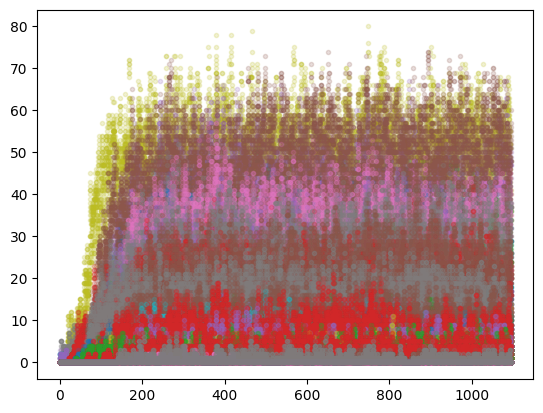

In [100]:
plt.plot(moving_average(tminisim_dict['ts'][:-1], 10), 10*moving_average_2d_hrz(np.hstack(tminisim_dict['mover_out']), 10).T , '.', alpha=0.2);